In [335]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import math

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import requests as re
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import plotly.express as px
from sklearn.cluster import KMeans

## Getting data through API

In [2]:
# Original data retrieved here.
api = "https://crashviewer.nhtsa.dot.gov/CrashAPI/FARSData/GetFARSData?dataset=Vehicle&FromYear=2020&&ToYear=2021&State=*&format=json"
res = re.get(api)

data = res.json()["Results"][0]

In [603]:
# Format as pandas DataFrame and save it to data folder
usefulColumns = ["DEATHS", "DR_DRINK", "DR_HGT", "DR_WGT", "HIT_RUNNAME", 
                 "TRAV_SP", "HOUR", "MOD_YEAR", "MODELNAME", "VSPD_LIM", "VPICBODYCLASSNAME",
                "NUMOCCS", "MAKENAME", "MINUTE"]

df = pd.DataFrame({k: [d[k] for d in data] for k in usefulColumns})

## Cleaning Data

### Firstly, convert all relevant data types to float

In [604]:
# Change Dtype to int for relevant columns
str_cols = ["MAKENAME", "VPICBODYCLASSNAME", "MODELNAME", "HIT_RUNNAME"]
type_change = {col: int for col in df.columns if col not in str_cols}
df = df.astype(type_change)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117142 entries, 0 to 117141
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DEATHS             117142 non-null  int32 
 1   DR_DRINK           117142 non-null  int32 
 2   DR_HGT             117142 non-null  int32 
 3   DR_WGT             117142 non-null  int32 
 4   HIT_RUNNAME        117142 non-null  object
 5   TRAV_SP            117142 non-null  int32 
 6   HOUR               117142 non-null  int32 
 7   MOD_YEAR           117142 non-null  int32 
 8   MODELNAME          117142 non-null  object
 9   VSPD_LIM           117142 non-null  int32 
 10  VPICBODYCLASSNAME  117142 non-null  object
 11  NUMOCCS            117142 non-null  int32 
 12  MAKENAME           117142 non-null  object
 13  MINUTE             117142 non-null  int32 
dtypes: int32(10), object(4)
memory usage: 8.0+ MB


### Only use the most common vehicles types

In [605]:
# Define the body categories to keep as they are
keep_categories = ['Sedan/Saloon', 'Sport Utility Vehicle (SUV)/Multi-Purpose Vehicle (MPV)', 
                   'Pickup', 'Hatchback/Liftback/Notchback', 'Coupe', 'Minivan', 'Truck-Tractor']

# Function to recategorize the data
def recategorize(row):
    if row in keep_categories:
        # Return entry as is if it is in the keep_categories list
        return row
    elif 'Motorcycle' in row:
        # Combine all motorcycle entries
        return 'Motorcycle'
    else:
        # Else return "Other", to be filtered out
        return 'Other'

# Apply the recategorize function to the body class name
df['VPICBODYCLASSNAME'] = df['VPICBODYCLASSNAME'].apply(recategorize)

# Finally, filter out all body types that are "Other"
df = df[df.VPICBODYCLASSNAME != "Other"]

# Now let's see the new value counts
print(df['VPICBODYCLASSNAME'].value_counts())

Sedan/Saloon                                               32284
Sport Utility Vehicle (SUV)/Multi-Purpose Vehicle (MPV)    24825
Pickup                                                     19495
Motorcycle                                                 12460
Truck-Tractor                                               6195
Coupe                                                       3697
Hatchback/Liftback/Notchback                                3313
Minivan                                                     2289
Name: VPICBODYCLASSNAME, dtype: int64


### Combine `HOUR` and `MINUTE`

In [606]:
df["TIME"] = df["HOUR"] + df["MINUTE"]/60

### Handle outliers and unknown information

In [607]:
# Remove speeds beyond 151 MPH
df = df[df['TRAV_SP'] <= 151]

# Include driver weights between 40-700 lbs and 
# driver heights between 40 and 107 inches
df = df[(df["DR_WGT"] >= 40) & (df["DR_WGT"] <= 700)]
df = df[(df["DR_HGT"] >= 40) & (df["DR_HGT"] <= 107)]

# Only include hours between 0 and 23
df = df[df["HOUR"] < 24]

# Remove unknown or undocumented model years
df = df[df['MOD_YEAR'] < 2021]

# Remove unknown make names (companies) and those with less than 100 occurences
value_counts = df['MAKENAME'].value_counts()
valid_makenames = value_counts[value_counts >= 10].index
exclusions = {"Unknown Make", "Other Make", "Other Import", "Other Domestic Manufacturers"}
valid_makenames = set(valid_makenames) - exclusions
df = df[df['MAKENAME'].isin(valid_makenames)]

### Map vehicle body type to average weights

In [608]:
def map_vehicle_to_weight(vehicle_type):
    # Define weight distributions (mean, std) for each vehicle type
    weight_distributions = {
        'Sedan/Saloon': (3300, 300),
        'Sport Utility Vehicle (SUV)/Multi-Purpose Vehicle (MPV)': (4500, 500),
        'Pickup': (5500, 600),
        'Motorcycle': (500, 100),
        'Coupe': (3300, 300),
        'Hatchback/Liftback/Notchback': (3300, 300),
        'Minivan': (4500, 400),
        'Truck-Tractor': (20000, 2000)
    }
    
    # Retrieve the distribution for the specified vehicle type
    distribution = weight_distributions.get(vehicle_type)
    
    if distribution:
        # Generate a random weight from the normal distribution
        mean, std = distribution
        return max(0, np.random.normal(mean, std))  # Ensure non-negative weights
    else:
        return "Unknown"

df["APRX_WGT"] = df["VPICBODYCLASSNAME"].map(map_vehicle_to_weight)

### Map boolean variables to 0 or 1

In [609]:
df["HIT_RUNNAME"] = df["HIT_RUNNAME"].map({"No":0, "Yes":1})

### Chunk model years into 5 year groupings.

In [610]:
df['MOD_YEAR_5YR_CHUNK'] = ((df['MOD_YEAR'].astype(int) + 2) // 5) * 5

### Remove unknown number of occupants

In [611]:
df = df[df["NUMOCCS"] < 99]

### Make a relative speed column (TRAV_SP - VSPD_LIM)

In [612]:
df['RELATIVE_SPEED'] = df["TRAV_SP"] - df["VSPD_LIM"] # positive values indicate speeding

### Make BMI

In [613]:
df["BMI"] = df['DR_WGT'] / df['DR_HGT']**2 * 703
# df.BMI = df.BMI.apply(lambda num: math.floor(num * 2) / 2)

### Create a target column called `DEATHOCCURRED` that is a boolean for whether or not anyone died.

In [614]:
df['DEATHOCCURRED'] = np.where(df['DEATHS'].astype(int) > 0, 1, 0)

### Data before one hot encoding of two categorical variables: `MAKENAME` and `VPICBODYCLASSNAME`

In [615]:
df = df.reset_index(drop = True)
df.to_csv("../data/data-clean/super-clean-vehicle-2020-2021.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23171 entries, 0 to 23170
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DEATHS              23171 non-null  int32  
 1   DR_DRINK            23171 non-null  int32  
 2   DR_HGT              23171 non-null  int32  
 3   DR_WGT              23171 non-null  int32  
 4   HIT_RUNNAME         23171 non-null  int64  
 5   TRAV_SP             23171 non-null  int32  
 6   HOUR                23171 non-null  int32  
 7   MOD_YEAR            23171 non-null  int32  
 8   MODELNAME           23171 non-null  object 
 9   VSPD_LIM            23171 non-null  int32  
 10  VPICBODYCLASSNAME   23171 non-null  object 
 11  NUMOCCS             23171 non-null  int32  
 12  MAKENAME            23171 non-null  object 
 13  MINUTE              23171 non-null  int32  
 14  TIME                23171 non-null  float64
 15  APRX_WGT            23171 non-null  float64
 16  MOD_

### One-hot encode categorical variables

In [616]:
categorical_columns = ['MAKENAME', 'VPICBODYCLASSNAME']  
df_onehot = pd.get_dummies(df, columns=categorical_columns)

## Models

### Implement random forest

In [617]:
drunk = df[df.DR_DRINK == 1]

In [618]:
drunk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4230 entries, 0 to 23166
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DEATHS              4230 non-null   int32  
 1   DR_DRINK            4230 non-null   int32  
 2   DR_HGT              4230 non-null   int32  
 3   DR_WGT              4230 non-null   int32  
 4   HIT_RUNNAME         4230 non-null   int64  
 5   TRAV_SP             4230 non-null   int32  
 6   HOUR                4230 non-null   int32  
 7   MOD_YEAR            4230 non-null   int32  
 8   MODELNAME           4230 non-null   object 
 9   VSPD_LIM            4230 non-null   int32  
 10  VPICBODYCLASSNAME   4230 non-null   object 
 11  NUMOCCS             4230 non-null   int32  
 12  MAKENAME            4230 non-null   object 
 13  MINUTE              4230 non-null   int32  
 14  TIME                4230 non-null   float64
 15  APRX_WGT            4230 non-null   float64
 16  MOD_Y

In [619]:
# Split data into features and target
X = drunk.drop(["DEATHS", "DEATHOCCURRED", "MODELNAME", 
             "MAKENAME", "VPICBODYCLASSNAME", 
               "MOD_YEAR_5YR_CHUNK"], axis=1)
y = drunk['DEATHOCCURRED']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Initialize and fit the Random Forest model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

# Get feature importances
feature_importances = rf.feature_importances_
feature_names = X.columns

# Create a DataFrame of features and their importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Output MSE and top 10 important features
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(feature_importance_df.head(25))

Accuracy: 81.80%
           Feature  Importance
11        APRX_WGT    0.140575
13             BMI    0.097186
10            TIME    0.096623
4          TRAV_SP    0.086642
12  RELATIVE_SPEED    0.085284
6         MOD_YEAR    0.082701
9           MINUTE    0.082323
2           DR_WGT    0.081794
1           DR_HGT    0.066359
5             HOUR    0.052213
7         VSPD_LIM    0.051765
3      HIT_RUNNAME    0.049460
8          NUMOCCS    0.027073
0         DR_DRINK    0.000000


### PCA analysis

In [620]:
features = df.drop(["DEATHS", "DEATHOCCURRED", "MODELNAME",  
                    "MAKENAME", "VPICBODYCLASSNAME"], axis=1)
target = df['DEATHOCCURRED']

X = features.values
X_norm = scale(X.astype(float))

# PCA Transformation
pca = PCA(n_components  = 3)
pca_result = pca.fit_transform(X_norm)

resDF = pd.DataFrame(pca_result, columns = ["PC1", "PC2", "PC3"])

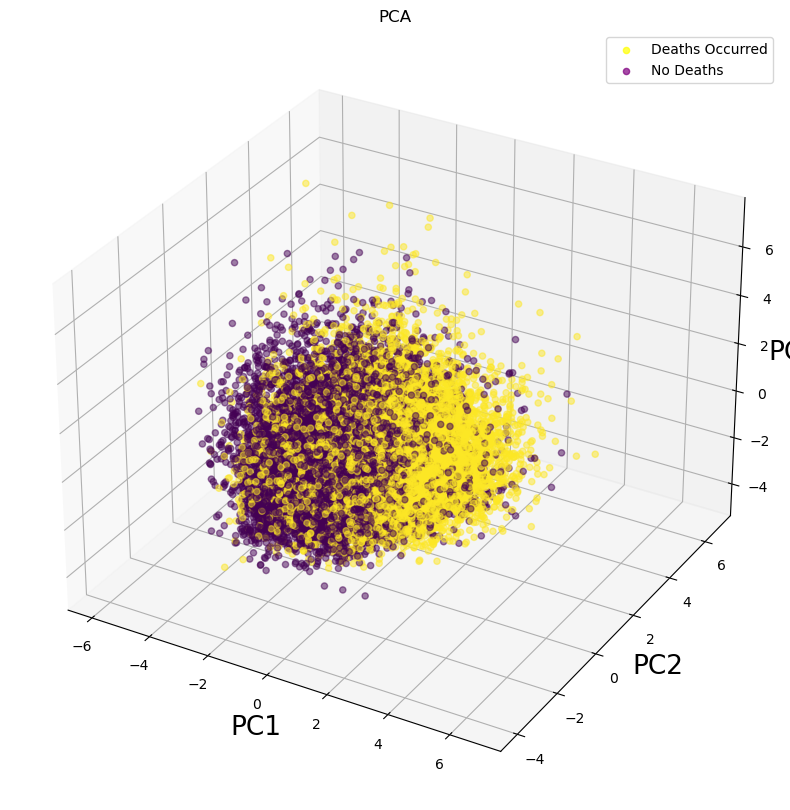

In [621]:
# Plotting the PCA results
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_result[:, 0], 
            pca_result[:, 1],
            pca_result[:, 2],
            c=target, 
            cmap='viridis', alpha=0.5)
plt.title('PCA')
# Create a scatter plot for each category to establish the colors
for i, color in enumerate(['yellow', 'purple']):
    ax.scatter([], [], c=color, label=['Deaths Occurred', 'No Deaths'][i], alpha=0.7)

# Add the legend to the plot
ax.legend()
ax.set_xlabel("PC1", fontsize = 19)
ax.set_ylabel("PC2", fontsize = 19)
ax.set_zlabel("PC3", fontsize = 19)
plt.show()

In [579]:
fig = px.scatter_3d(resDF, x='PC1', y='PC2', z='PC3',
              color=df.DEATHOCCURRED)
fig.write_html('../html/PCA.html', auto_open=True)

30
acc: 0.6637175780069915


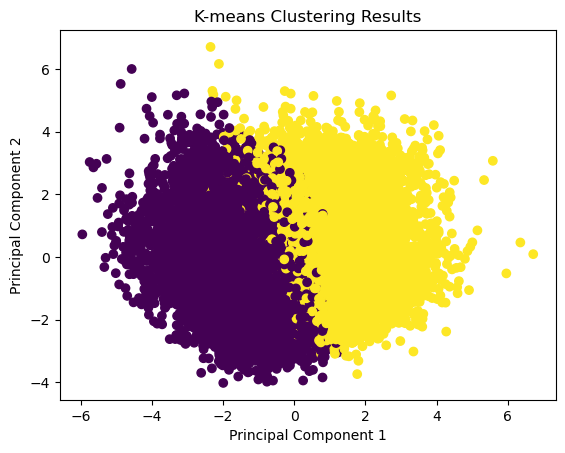

31
acc: 0.6596607828751456


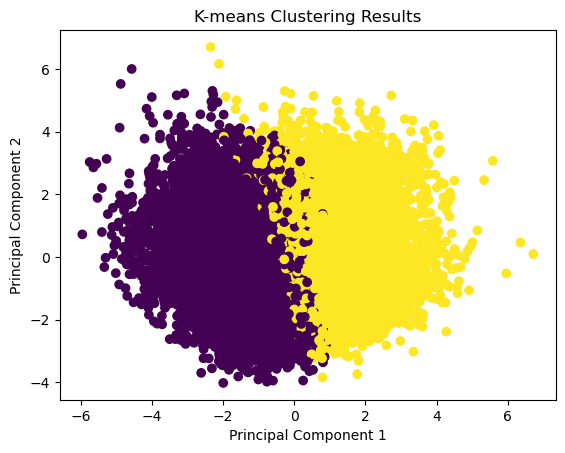

32
acc: 0.4850891200207155


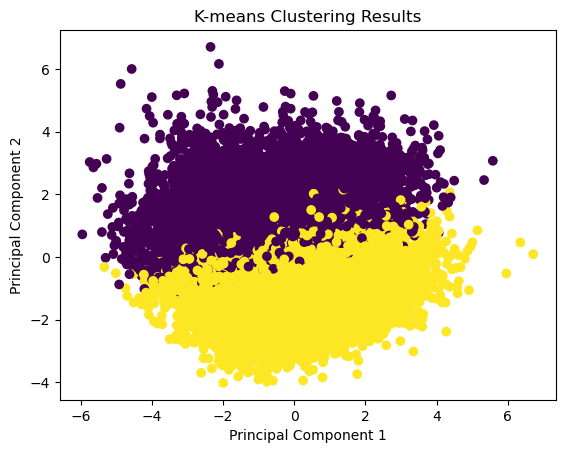

33
acc: 0.34085710586509


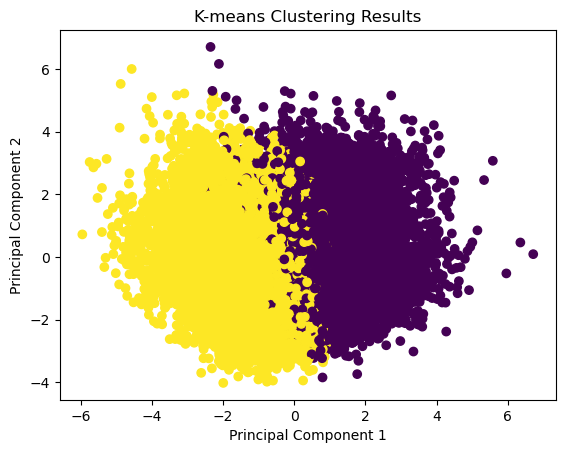

34
acc: 0.6635881058219326


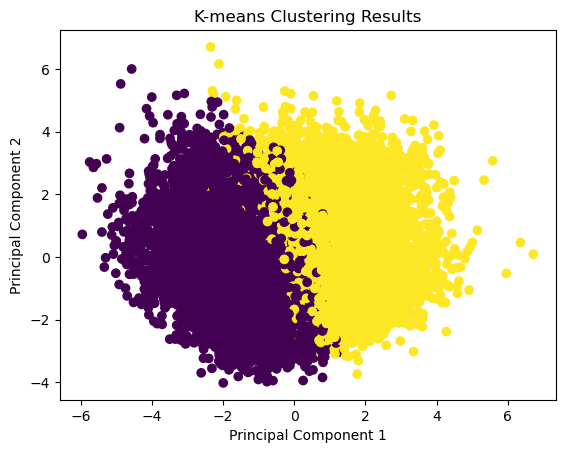

35
acc: 0.3362824219930085


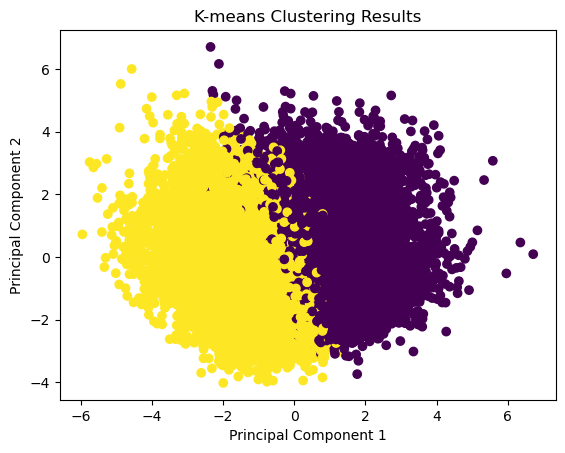

36
acc: 0.6596607828751456


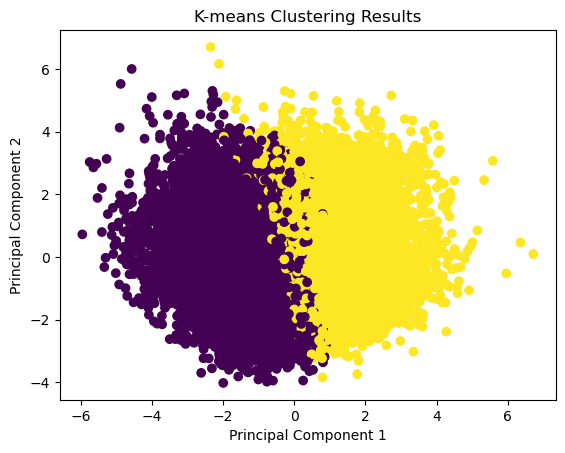

37
acc: 0.6595313106900867


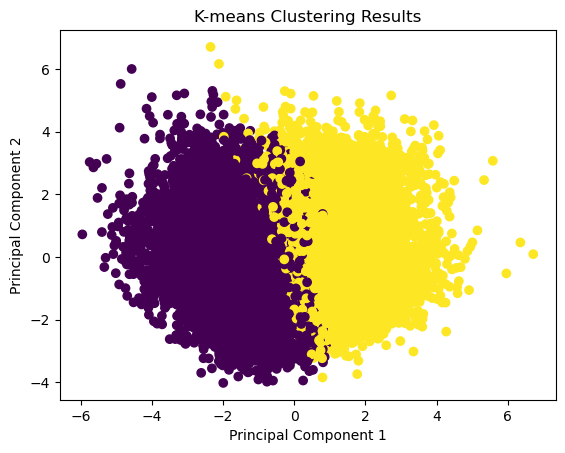

38
acc: 0.4746881878209831


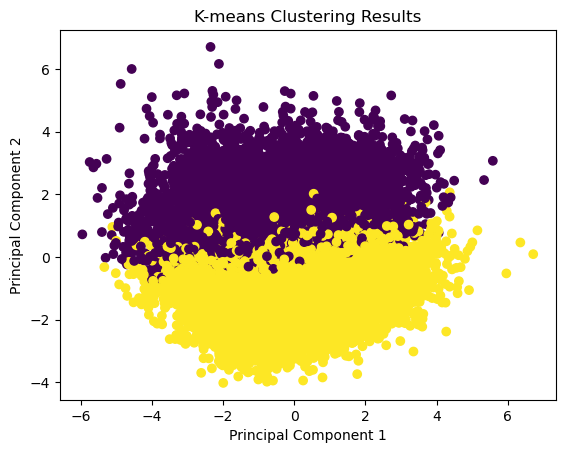

39
acc: 0.47274610504509945


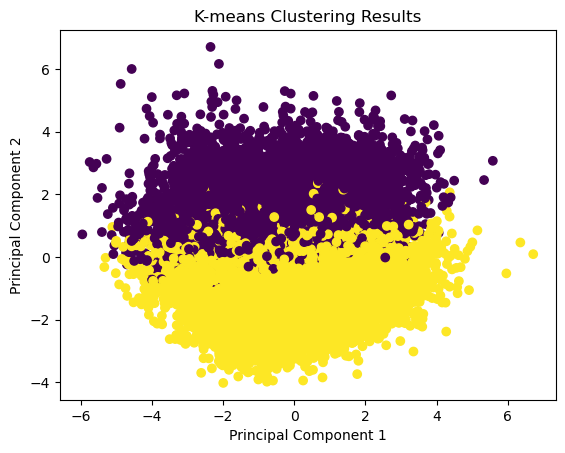

In [580]:
for num in range(30, 40):
    print(num)
    kmeans = KMeans(n_clusters=2, random_state = num, n_init = "auto")  # Specify the number of clusters
    clusters = kmeans.fit_predict(pca_result)
    
    df_clusters = df.copy()
    df_clusters["CLUSTERS"] = clusters
    acc = (df_clusters.CLUSTERS == df_clusters.DEATHOCCURRED).sum()/len(df_clusters.CLUSTERS)
    print(f"acc: {acc}")

    # Plotting the results
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('K-means Clustering Results')
    plt.show()

#### Clustered it into two clusters because the PCA analysis shows one cluster with a heterogenous mix of fatality/no fatality where the two smaller clusters are 0 fatalities.

In [440]:
df_clusters = df.copy()
df_clusters["CLUSTERS"] = clusters
acc = (df_clusters.CLUSTERS == df_clusters.DEATHOCCURRED).sum()/len(df_clusters.CLUSTERS)
acc

0.34741702990807477

In [441]:
# Change Dtype to int for relevant columns
str_cols = ["MAKENAME", "VPICBODYCLASSNAME", "MODELNAME"]
type_change = {col: int for col in df_clusters.columns if col not in str_cols}
df_clusters = df_clusters.astype(type_change)
df_clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23171 entries, 0 to 23170
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   DEATHS              23171 non-null  int32 
 1   DR_DRINK            23171 non-null  int32 
 2   DR_HGT              23171 non-null  int32 
 3   DR_WGT              23171 non-null  int32 
 4   HIT_RUNNAME         23171 non-null  int32 
 5   TRAV_SP             23171 non-null  int32 
 6   HOUR                23171 non-null  int32 
 7   MOD_YEAR            23171 non-null  int32 
 8   MODELNAME           23171 non-null  object
 9   VSPD_LIM            23171 non-null  int32 
 10  VPICBODYCLASSNAME   23171 non-null  object
 11  NUMOCCS             23171 non-null  int32 
 12  MAKENAME            23171 non-null  object
 13  APRX_WGT            23171 non-null  int32 
 14  MOD_YEAR_5YR_CHUNK  23171 non-null  int32 
 15  RELATIVE_SPEED      23171 non-null  int32 
 16  BMI                 23

In [442]:
df_clusters.drop(columns = str_cols).groupby("CLUSTERS").mean()

,DEATHS,DR_DRINK,DR_HGT,DR_WGT,HIT_RUNNAME,TRAV_SP,HOUR,MOD_YEAR,VSPD_LIM,NUMOCCS,APRX_WGT,MOD_YEAR_5YR_CHUNK,RELATIVE_SPEED,BMI,DEATHOCCURRED
CLUSTERS,,,,,,,,,,,,,,,
0,0.704635,0.305923,68.930565,183.521475,0.019148,58.441840,13.353883,2003.938708,50.157928,1.454724,3908.678776,2003.831872,8.283912,26.576682,0.655243
1,0.381242,0.067612,68.110963,187.108545,0.007336,37.791913,13.283702,2014.167153,51.914381,1.494873,5627.403585,2014.293456,-14.122468,27.708128,0.349896


In [443]:
df_clusters[df_clusters['CLUSTERS'] == 0].NUMOCCS.max()

25

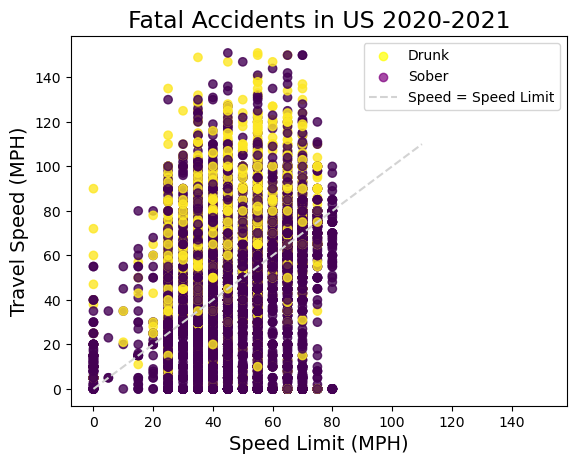

In [627]:
fig, ax = plt.subplots()

mask = (df.TRAV_SP < 200) & (df.VSPD_LIM < 90)
ax.scatter(df.VSPD_LIM[mask], 
           df.TRAV_SP[mask], 
           c = df.DR_DRINK[mask], alpha = 0.8)
ax.set_xlim(ax.get_ylim())

x = np.linspace(0, 110, 1000)
for i, color in enumerate(['yellow', 'purple']):
    ax.scatter([], [], c=color, label=['Drunk', 'Sober'][i], alpha=0.7)
    
ax.plot(x, x, '--', color = "lightgrey", label = "Speed = Speed Limit")
ax.legend()

ax.set_title("Fatal Accidents in US 2020-2021", fontsize = 17)
ax.set_xlabel("Speed Limit (MPH)", fontsize = 14)
ax.set_ylabel("Travel Speed (MPH)", fontsize = 14)
plt.savefig("../plots/travelSpeed_vs_speedLimit.png")
plt.show()

In [445]:
df.VPICBODYCLASSNAME.value_counts()

Sedan/Saloon                                               7216
Sport Utility Vehicle (SUV)/Multi-Purpose Vehicle (MPV)    5659
Pickup                                                     4474
Motorcycle                                                 2190
Truck-Tractor                                              1407
Coupe                                                       833
Hatchback/Liftback/Notchback                                816
Minivan                                                     576
Name: VPICBODYCLASSNAME, dtype: int64

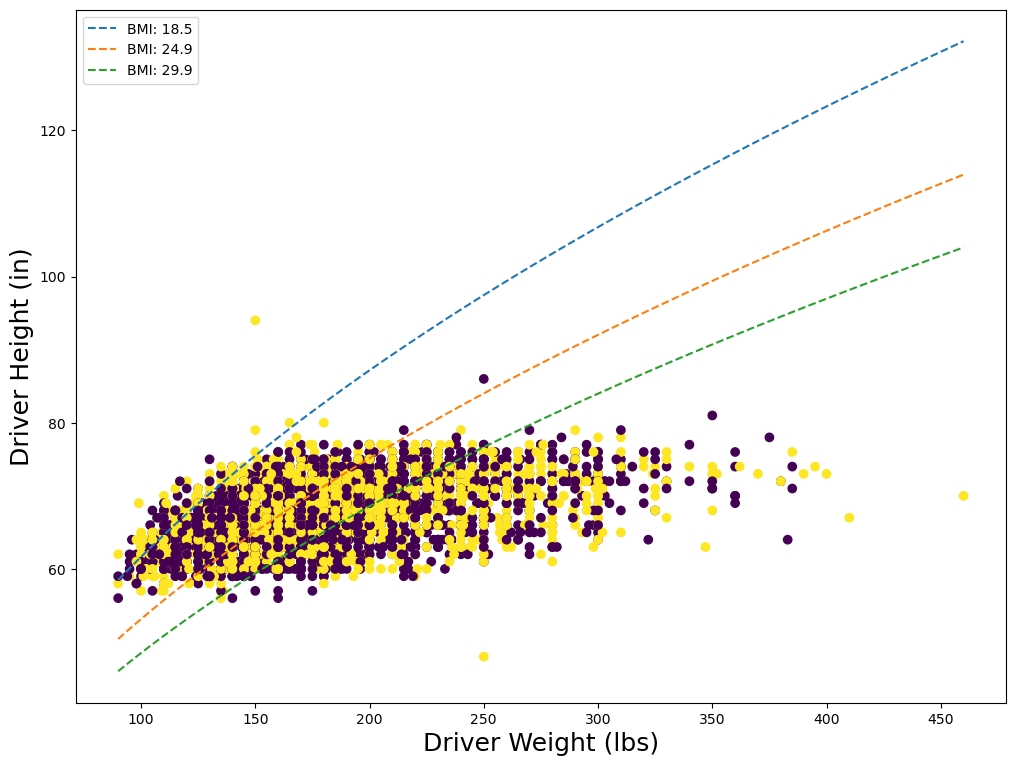

In [446]:
fig, ax = plt.subplots(figsize = (12, 9))

df_sedan = df[df["VPICBODYCLASSNAME"] == "Sport Utility Vehicle (SUV)/Multi-Purpose Vehicle (MPV)"]

ax.scatter(df_sedan.DR_WGT.astype(float), 
           df_sedan.DR_HGT.astype(float), 
           c = df_sedan.DEATHOCCURRED)

def height_by_BMI(weight, BMI):
    
    h = np.sqrt(weight/BMI * 703)
    
    return h 


bmis = [18.5, 24.9, 29.9]

for bmi in bmis:
    w = np.linspace(np.min(df_sedan.DR_WGT.astype(float)), np.max(df_sedan.DR_WGT.astype(float)), 100)
    ax.plot(w, height_by_BMI(w, bmi), '--', alpha = 1, label = f"BMI: {bmi}")

ax.set_xlabel("Driver Weight (lbs)", fontsize = 18)
ax.set_ylabel("Driver Height (in)", fontsize = 18)
ax.legend()
plt.show()
